In [20]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib widget

sys.path.insert(0, '../../drlib')
import drlib as dr

mean =  -102.742043594991 dBm
std =  4.652475499570036 dBm
1553


"\n\nplt.figure()\nplt.hist(power, bins = 25);\nplt.title('Bicon In Room')\n"

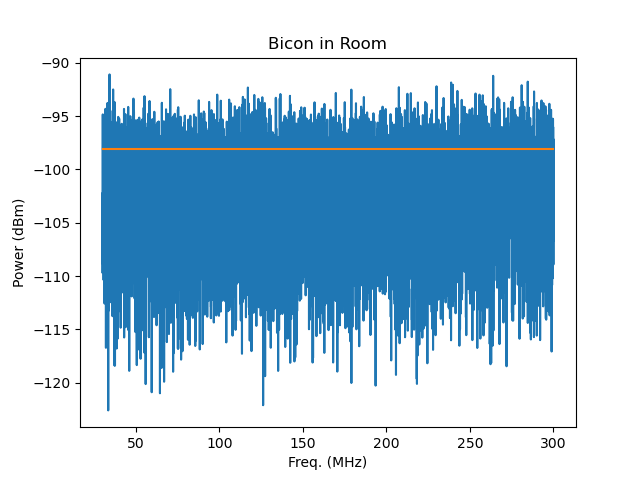

In [34]:
freqs, power = np.load('./biconInRoom_1avg_0Gain_10kpts_RBW30kHz_30to300MHz_preampOff_0Att.npy')


print('mean = ', power.mean(), 'dBm')
print('std = ', power.std(), 'dBm')

mean = power.mean()
std = power.std()


plt.close('all')
plt.figure()

plt.plot(freqs/1e6, power)
plt.xlabel('Freq. (MHz)')
plt.ylabel('Power (dBm)')
plt.title('Bicon in Room')
plt.plot((30,300), (mean + 1*std, mean + 1*std))

print((power>(mean + std)).sum())


'''

plt.figure()
plt.hist(power, bins = 25);
plt.title('Bicon In Room')
'''


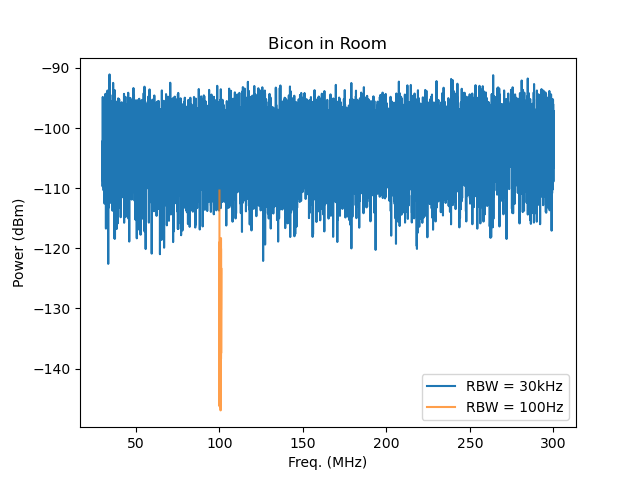

In [3]:
freqsfull, powerfull = np.load('./biconInRoom_1avg_0Gain_10kpts_RBW30kHz_30to300MHz_preampOff_0Att.npy')

freqszoom, powerzoom = np.load('./biconInRoom_1avg_0Gain_10kpts_RBW100Hz_100to101MHz_preampOff_0Att.npy')


plt.close('all')
plt.figure()

plt.plot(freqsfull/1e6, powerfull, label = 'RBW = 30kHz')
plt.plot(freqszoom/1e6, powerzoom, alpha = .75, label = 'RBW = 100Hz')
plt.xlabel('Freq. (MHz)')
plt.ylabel('Power (dBm)')
plt.title('Bicon in Room')
plt.legend()

mean of output referred power =  -156.25839924870294
lin mean of output referred power =  -156.25839924870294
theoritical Johnson noise for 350 K 100 Hz RBW =  -153.1605286924849
remember impedance match of antenna!!


Text(0.5, 1.0, 'Output Referred Bicon in Room')

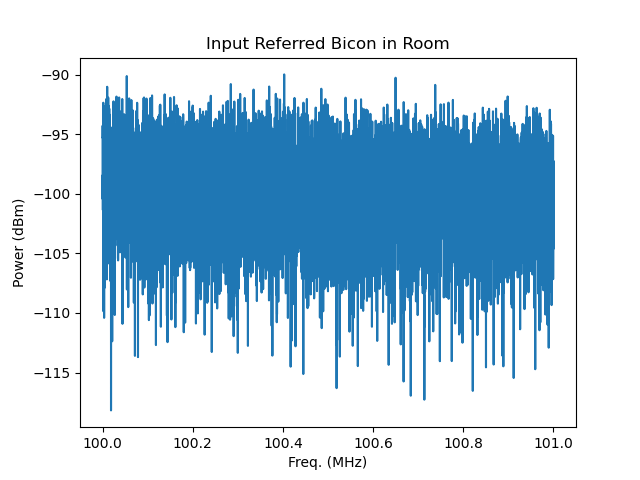

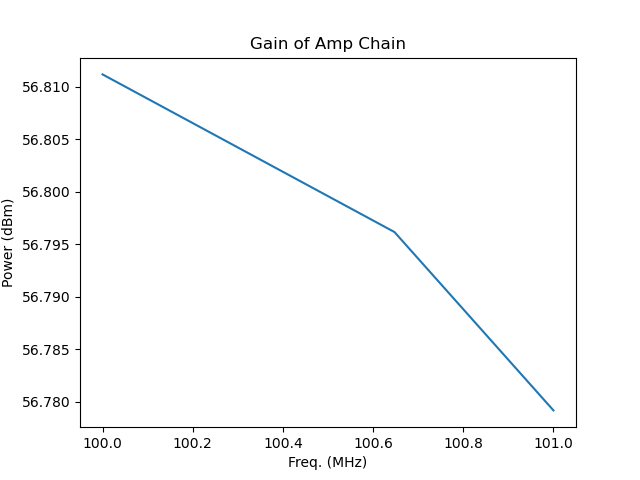

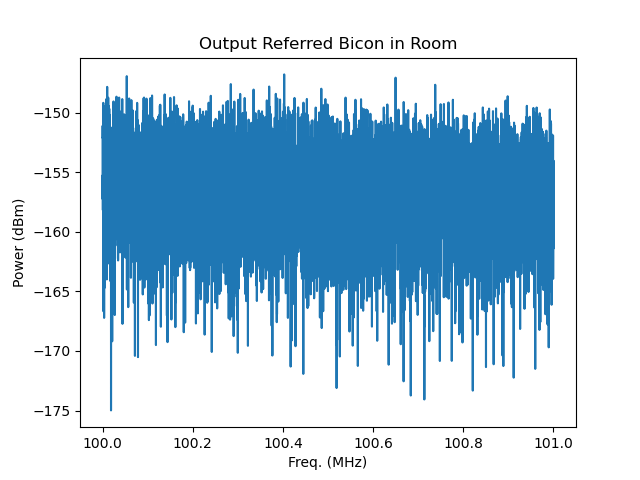

In [19]:
freqs, power = np.load('./biconInRoom_1avg_56dBGain_10kpts_RBW100Hz_100to101MHz_preampOff_0Att.npy')
freqs, gain= dr.getExtGain(freqsInterp = freqs)

linMean = 10**((power - gain)/10).mean()
linMeandBm = 10*np.log10(linMean)
print("mean of output referred power = ", (power - gain).mean())
print("lin mean of output referred power = ", linMeandBm)

k = 1.38e-23
temp = 350
rbw = 100
pJohnsondBm = 10 * np.log10(k * temp * rbw * 1000)

print('theoritical Johnson noise for', T, 'K', 100, 'Hz RBW = ', pJohnsondBm )

print('remember impedance match of antenna!!')

plt.close('all')

plt.figure()
plt.plot(freqs/1e6, power)
plt.xlabel('Freq. (MHz)')
plt.ylabel('Power (dBm)')
plt.title('Input Referred Bicon in Room')

plt.figure()
plt.plot(freqs/1e6, gain)
plt.xlabel('Freq. (MHz)')
plt.ylabel('Power (dBm)')
plt.title('Gain of Amp Chain')

plt.figure()
plt.plot(freqs/1e6, power - gain)
plt.xlabel('Freq. (MHz)')
plt.ylabel('Power (dBm)')
plt.title('Output Referred Bicon in Room')


Text(0.5, 1.0, 'Output Referred Bicon in Room')

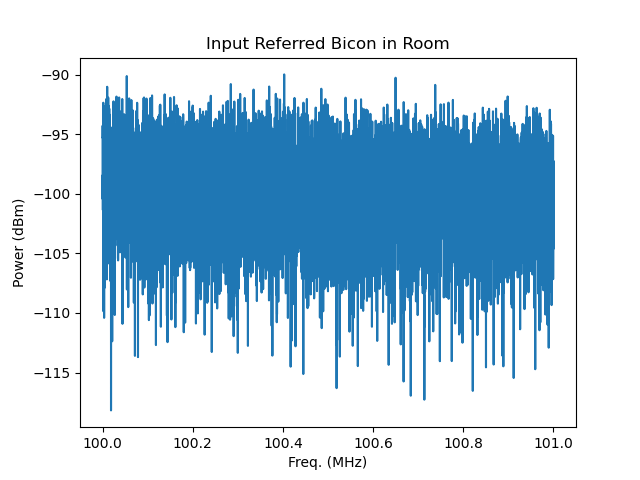

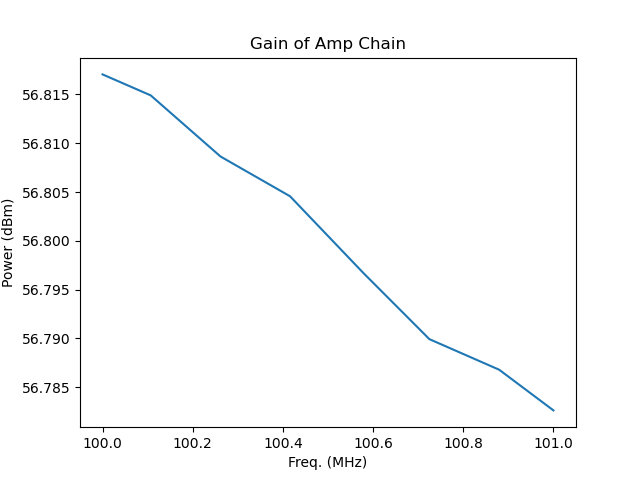

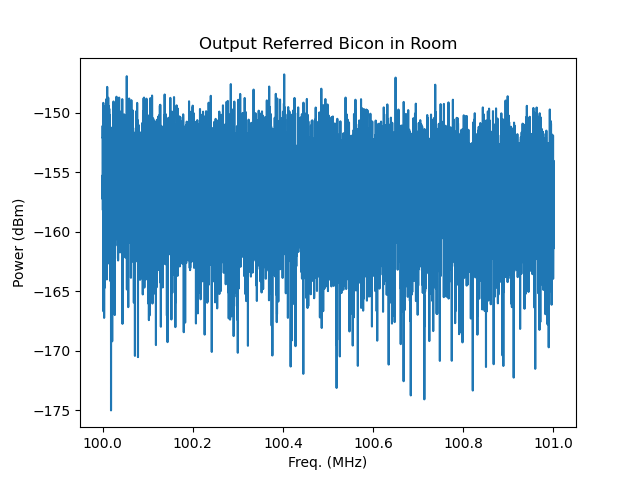

In [43]:
freqs, power = np.load('./biconInRoom_1avg_56dBGain_10kpts_RBW100Hz_100to101MHz_preampOff_0Att.npy')
freqs, gain= dr.getExtGain(freqsInterp = freqs, lengthMean = 5)




plt.close('all')

plt.figure()
plt.plot(freqs/1e6, power)
plt.xlabel('Freq. (MHz)')
plt.ylabel('Power (dBm)')
plt.title('Input Referred Bicon in Room')

plt.figure()
plt.plot(freqs/1e6, gain)
plt.xlabel('Freq. (MHz)')
plt.ylabel('Power (dBm)')
plt.title('Gain of Amp Chain')

plt.figure()
plt.plot(freqs/1e6, power - gain)
plt.xlabel('Freq. (MHz)')
plt.ylabel('Power (dBm)')
plt.title('Output Referred Bicon in Room')